In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import os

datpath = "/Users/dharineeshsomisetty/Downloads/hw2data/"
# Load training data
def load_data(file_list):
    data = []
    for file in file_list:
        sample = np.load("/Users/dharineeshsomisetty/Downloads/hw2data/"+file)  # Shape: (114, 100)
        data.append(sample)
    data = np.concatenate(data, axis=1)  # Shape: (114, 1500)
    return data.T  # Transpose to (1500, 114)

# Specify file paths for training and test data
train_files = [
    "train/jumping_1.npy", "train/jumping_2.npy", "train/jumping_3.npy", "train/jumping_4.npy", "train/jumping_5.npy",
    "train/running_1.npy", "train/running_2.npy", "train/running_3.npy", "train/running_4.npy", "train/running_5.npy",
    "train/walking_1.npy", "train/walking_2.npy", "train/walking_3.npy", "train/walking_4.npy", "train/walking_5.npy"
]
test_files = ["test/jumping_1t.npy", "test/running_1t.npy", "test/walking_1t.npy"]

# Load and prepare the data
X_train = load_data(train_files)
ground_truth = np.repeat([0, 1, 2], 5)  # 0: Jumping, 1: Running, 2: Walking
print(f"Shape of X_train: {X_train.shape}")

Shape of X_train: (1500, 114)


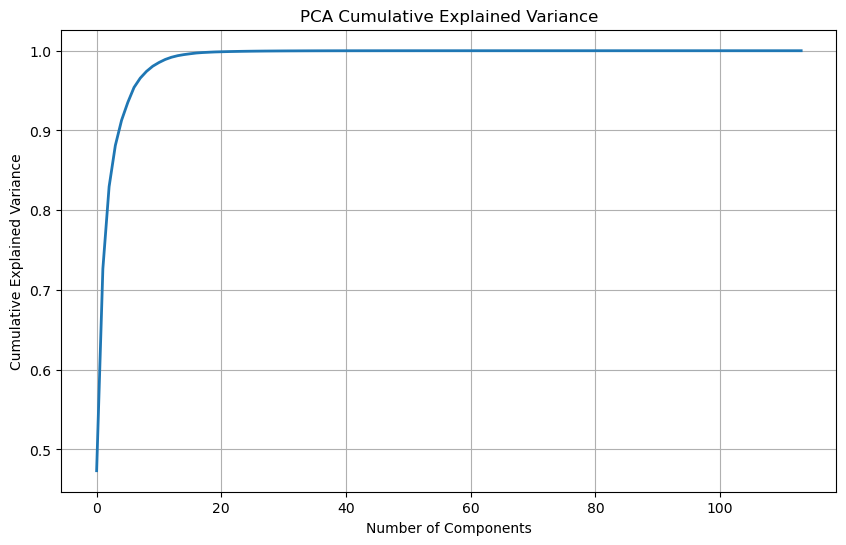

In [2]:
# Task 1: PCA and cumulative energy plot
pca = PCA()
pca.fit(X_train)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid(True)
plt.show()


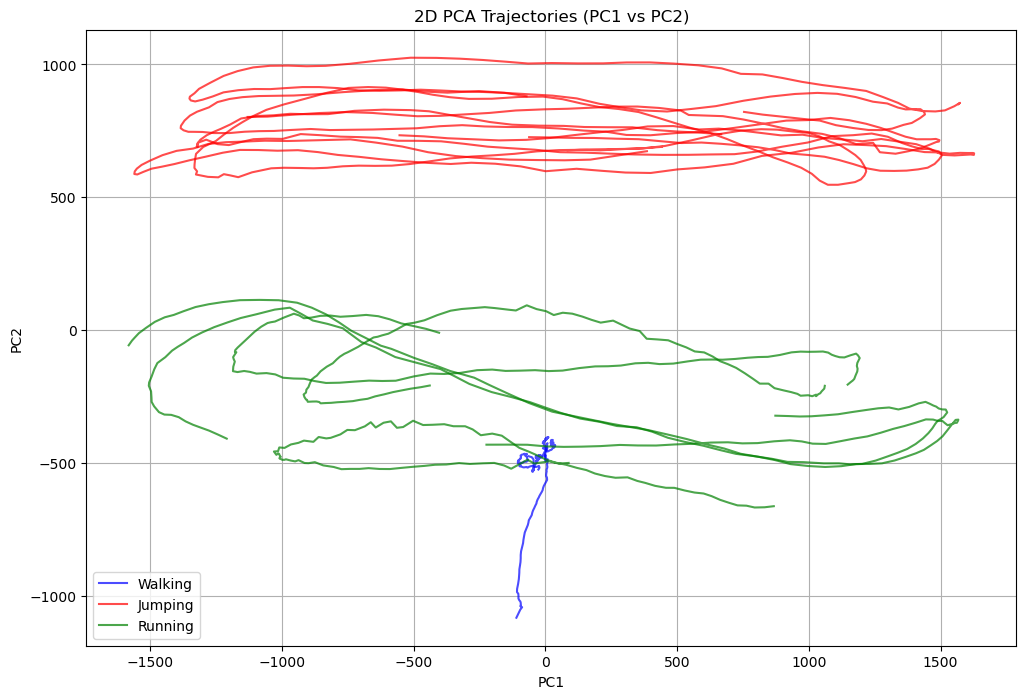

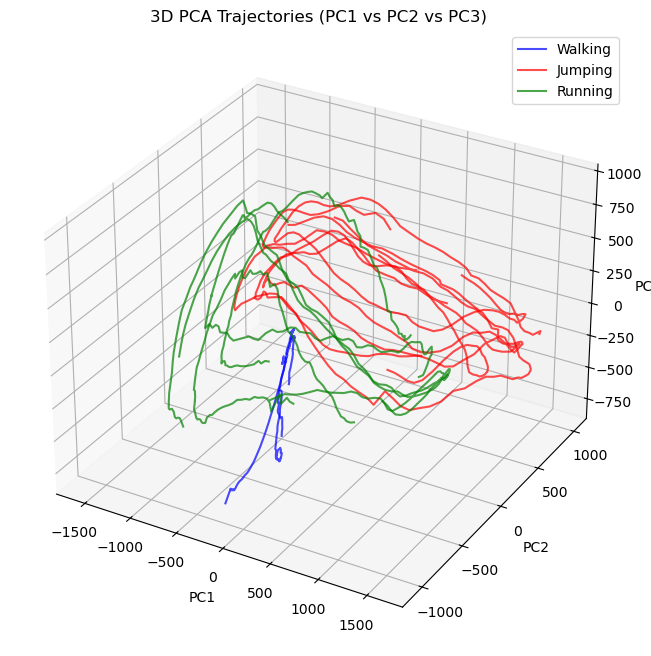

In [3]:
#Task 2
from mpl_toolkits.mplot3d import Axes3D

# Plotting function for 2D and 3D trajectories
def plot_trajectories(X_pca, n_components, title):
    plt.figure(figsize=(12, 8))
    
    colors = ['blue', 'red', 'green']
    labels = ['Walking', 'Jumping', 'Running']
    
    if n_components == 3:
        ax = plt.axes(projection='3d')
    
    for i in range(15):
        class_idx = i // 5  # Determine the class (0: walking, 1: jumping, 2: running)
        traj = X_pca[i*100:(i+1)*100]
        
        if n_components == 2:
            plt.plot(traj[:, 0], traj[:, 1], color=colors[class_idx], alpha=0.7, label=labels[class_idx] if i % 5 == 0 else "")
        else:
            ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=colors[class_idx], alpha=0.7, label=labels[class_idx] if i % 5 == 0 else "")
    
    if n_components == 2:
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title(title)
        plt.legend()
        plt.grid(True)
    else:
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_title(title)
        ax.legend()
    
    plt.show()

# Task 2: Project the data onto 2 and 3 components
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_train)
plot_trajectories(X_pca2, 2, '2D PCA Trajectories (PC1 vs PC2)')

pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_train)
plot_trajectories(X_pca3, 3, '3D PCA Trajectories (PC1 vs PC2 vs PC3)')

In [4]:
# Task 3: Compute centroids
def compute_centroids(X_pca, k):
    centroids = []
    for i in range(3):  # Three classes: Jumping, Running, Walking
        centroid = np.mean(X_pca[i*500:(i+1)*500], axis=0)
        centroids.append(centroid)
    return centroids


In [5]:
# Task 4: Evaluate classifier for different k values
def evaluate_accuracy(k, X_train, ground_truth):
    pca_k = PCA(n_components=k)
    X_pca_k = pca_k.fit_transform(X_train)
    centroids = compute_centroids(X_pca_k, k)
    
    sample_means = [np.mean(X_pca_k[i*100:(i+1)*100], axis=0) for i in range(15)]
    
    predicted = []
    for mean in sample_means:
        distances = [np.linalg.norm(mean - c) for c in centroids]
        predicted.append(np.argmin(distances))
    
    return accuracy_score(ground_truth, predicted)

# Test different k values
k_list = [2, 3, 5, 10, 15]
train_accuracies = {}
for k in k_list:
    acc = evaluate_accuracy(k, X_train, ground_truth)
    train_accuracies[k] = acc
    print(f"Training Accuracy (k={k}): {acc:.2f}")

Training Accuracy (k=2): 0.93
Training Accuracy (k=3): 0.80
Training Accuracy (k=5): 0.80
Training Accuracy (k=10): 1.00
Training Accuracy (k=15): 1.00


In [ ]:
# Task 5: Test classifier on new samples
def test_classifier(pca_model, centroids, test_files):
    test_samples = [np.load("/Users/dharineeshsomisetty/Downloads/hw2data/"+ file).T for file in test_files]  # Shape: (100, 114) for each file
    test_means = [np.mean(pca_model.transform(sample), axis=0) for sample in test_samples]
    
    predicted = []
    for mean in test_means:
        distances = [np.linalg.norm(mean - c) for c in centroids]
        predicted.append(np.argmin(distances))
    
    return predicted

# Example for k=2 (because seems like k=2 is giving a better accuracy compared to k=3 or k=5)
pca_k2 = PCA(n_components=2)
X_pca_k2 = pca_k2.fit_transform(X_train)
centroids_k2 = compute_centroids(X_pca_k2, 2)
test_predictions = test_classifier(pca_k2, centroids_k2, test_files)
print(f"Test Predictions (k=2): {test_predictions}")

Test Predictions (k=2): [0, 1, 2]
